# Opdracht
## XML-dataset

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd

xml_data = open('processen50000.xml', 'r').read()  # Read file
# root = ET.XML(xml_data)  # Parse XML

df = pd.read_xml(xml_data)

In [2]:
df.head()

,pid,arrivaltime,servicetime
0,1,358,94
1,2,530,122
2,3,665,30
3,4,774,83
4,5,1231,26


De tijden zijn niet in seconden, maar in aantal JIFFY’s. Een JIFFY is de tijd tussen twee “system timer”-interrupts. Er kan enkel gescheduled worden, beslissen welk proces aan de beurt is, bij een interrupt. Hier is de waarde van de JIFFY 10 ms.

## Processtrategiën
FCFS, SJF, SRT, RR, HRRN, en multilevel feedback mode.

Van het FCFS, SJF, SRT en HRRN algoritme maak je 1 versie. Het RR algoritme wordt geïmplementeerd met time slices q = 2, q = 4 en q = 8.
Voor het multilevel feedback algoritme maak je twee versies, telkens met 5 wachtrijen. Maak hier zelf een goeie keuze voor de time slices per wachtrij.
Motiveer de keuze in het verslag. Uiteraard mag je er meer implementeren dan deze. Schenk bij de implementatie van deze strategie¨en aandacht aan het ontwerp.
Indien de modellering goed verlopen is, zal je minder problemen hebben in deze fase.


### FCFS
First Come First Served.
Implementatie: simpel, steeds bij de arrival time de service time optellen en kijken of het volgende proces heeft gewacht of niet.

In [3]:
df_fcfs = df.copy()

In [4]:
# uitvoeren van de scheduler en berekenen van de grootheden per proces:
df_fcfs["starttime"] = df_fcfs["arrivaltime"]
df_fcfs["waittime"] = 0
df_fcfs["endtime"] = df_fcfs["arrivaltime"] + df_fcfs["servicetime"]

for i in range(1, 50000):
    # als het proces toekomt alvorens het vorige proces klaar is (deze if loop is als het ware de scheduler):
    if df_fcfs.at[i-1, "endtime"] > df_fcfs.at[i, "arrivaltime"]: 
        # wachttijd berekenen
        df_fcfs.at[i, "waittime"] = df_fcfs.at[i-1, "endtime"] - df_fcfs.at[i, "arrivaltime"] 
        # starttijd bijstellen met wachttijd
        df_fcfs.at[i, "starttime"] = df_fcfs.at[i-1, "endtime"] 
    # eindtijd berekenen op basis van (aangepaste) starttijd en bedieningstijd
    df_fcfs.at[i, "endtime"] = df_fcfs.at[i, "starttime"] + df_fcfs.at[i, "servicetime"] 
# Na het uitvoeren van de scheduler berekenen we de TAT zoals gezien in de les: service time + wait time    
df_fcfs["TAT"] = df_fcfs["servicetime"] + df_fcfs["waittime"]
# idem voor de genormaliseerde TAT:
df_fcfs["normTAT"] = df_fcfs["TAT"]/df_fcfs["servicetime"]

df_fcfs.head(-20)

,pid,arrivaltime,servicetime,starttime,waittime,endtime,TAT,normTAT
0,1,358,94,358,0,452,94,1.000000
1,2,530,122,530,0,652,122,1.000000
2,3,665,30,665,0,695,30,1.000000
3,4,774,83,774,0,857,83,1.000000
4,5,1231,26,1231,0,1257,26,1.000000
...,...,...,...,...,...,...,...,...
49975,49976,6207751,52,6207789,38,6207841,90,1.730769
49976,49977,6208026,67,6208026,0,6208093,67,1.000000
49977,49978,6208055,105,6208093,38,6208198,143,1.361905
49978,49979,6208116,1,6208198,82,6208199,83,83.000000


In [5]:
# berekenen globale parameters:

def global_params(df, title):
    ''' functie voor de globale parameters bruikbaar voor elke strategie '''
    # gemiddelde omlooptijd:
    tat = df["TAT"].mean()

    # gemiddelde genormaliseerde omlooptijd:
    normtat = df["normTAT"].mean()

    # gemiddelde genormaliseerde omlooptijd:
    wait = df["waittime"].mean()

    params = (tat, normtat, wait)
    
    print("===================")
    print(title)
    print("===================")
    print ("gemiddelde omlooptijd bedraagt: "+ str(tat))
    print ("gemiddelde genormaliseerde omlooptijd bedraagt: "+ str(normtat))
    print ("gemiddelde wachttijd bedraagt: "+ str(wait))
    return params

params_fcfs = global_params(df_fcfs, "FCFS")
params_fcfs

FCFS
gemiddelde omlooptijd bedraagt: 505.32718
gemiddelde genormaliseerde omlooptijd bedraagt: 23.26153566913487
gemiddelde wachttijd bedraagt: 405.80196


(505.32718, 23.26153566913487, 405.80196)

In [6]:
import numpy as np

# omzetten naar percentielen voor grafieken ( we maken hier een functie die we kunnen herbruiken
def df_to_perc(df):
    ''' turns a dataframe with 50000 rows into one with 100 rows containing averages of every group of  500 rows of the original dataframe '''
    df_sort = df.sort_values('servicetime', axis = 0)
    df_perc = df_sort.groupby(np.arange(len(df_sort))//500).mean()
    df_fin = df_perc.drop(['pid','arrivaltime', 'starttime', 'TAT', 'endtime'], axis = 1)
    return df_fin

In [7]:
df_to_perc(df_fcfs)

,servicetime,waittime,normTAT
0,1.000,414.590,415.590000
1,1.190,425.310,382.772000
2,2.168,401.140,188.998333
3,3.144,382.812,123.647833
4,4.194,390.504,95.018600
...,...,...,...
95,312.652,371.832,2.187585
96,337.308,423.742,2.253079
97,369.286,422.428,2.143853
98,421.414,388.250,1.924774


FCFS
gemiddelde omlooptijd bedraagt: 505.32718
gemiddelde genormaliseerde omlooptijd bedraagt: 23.26153566913487
gemiddelde wachttijd bedraagt: 405.80196


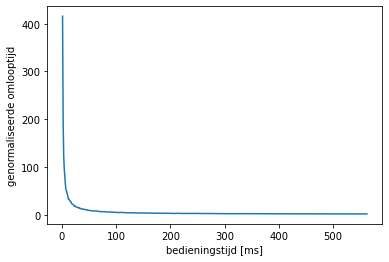

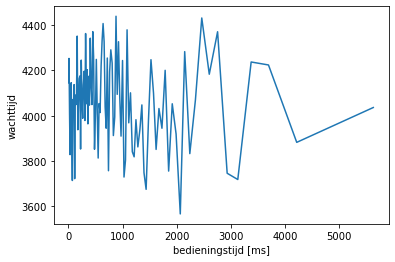

In [11]:
import matplotlib.pyplot as plt

def evaluate(df, title):
    ''' functie die de hele evaluatie maakt en uitprint van een dataframe die de nodige waarden bevat voor een scheduling strategie '''
    params = global_params(df, title)
    df_plot = df_to_perc(df)
    plt.plot(df_plot['servicetime'], df_plot['normTAT'])
    plt.xlabel('bedieningstijd [ms]')
    plt.ylabel('genormaliseerde omlooptijd')
    plt.show()
    
    plt.plot(df_plot['servicetime']*10, df_plot['waittime']*10)
    plt.xlabel('bedieningstijd [ms]')
    plt.ylabel('wachttijd')
    plt.show()
    
evaluate(df_fcfs, "FCFS")
    


## Evaluatie testresultaten

Voor het evalueren van de scheduler bepaal je aan de hand van een testrun een aantal grootheden:
- per proces: aankomsttijd, bedieningstijd , starttijd, eindtijd, omlooptijd, genormaliseerde omlooptijd en wachttijd
- globale parameters: gemiddelde omlooptijd, gemiddelde genormaliseerde omlooptijd en gemiddelde wachttijd

De resultaten breng je in twee grafieken:
- genormaliseerde omlooptijd in functie van bedieningstijd
- wachttijd in functie van bedieningstijd

De bedieningstijd verdeel je in percentielen. Voorbeeld voor 20000 processen: het eerste percentiel bestaat
uit de 200 kortste bedieningstijden.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, y)
ax2.plot(x, -y)